We can now use the code we just completed to get a batch of images from your train data loader and look at them.

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


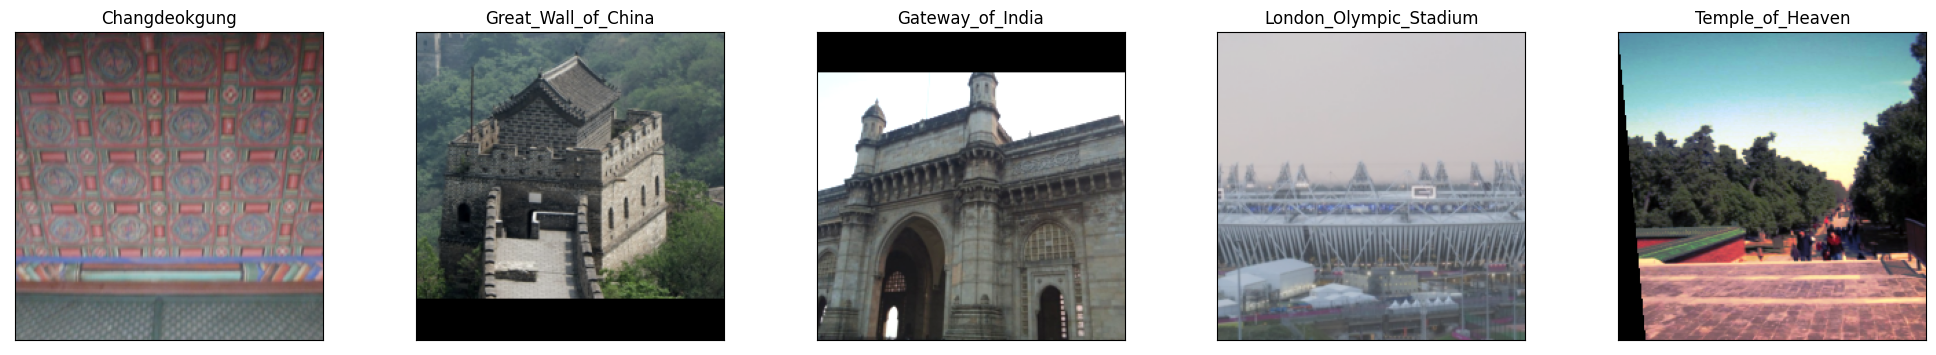

In [10]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders()

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

Allright, good job getting here! Now it's time to see if all our hard work pays off. In the following cell we will train your model and validate it against the validation set.

Let's start by defining a few hyperparameters. Feel free to experiment with different values and try to optimize your model:

In [3]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 75         # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0     # regularization. Increase this to combat overfitting

In [4]:
import numpy as np
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.train import one_epoch_test
from src.model import MyModel
import mlflow
from random import choices
import torch

Deletes all previous run throughs. The Udacity workspace has limited disk space so we need to delete previous run throughs or we will get an error during our training due to running out of disk space as we log the artifacts.

In [15]:
# Find any previous runs from previous run-throughs and deletes them.
runs = mlflow.search_runs()
print(f'Found {len(runs)} existing runs from previous testing.')
for i, run in runs.iterrows():
    mlflow.delete_run(run['run_id'])

# Permanently deletes from the disk space our deleted runs.
!mlflow gc

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 880, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 691, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/utils/file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/notebooks/mlruns/0/.ipynb_checkpoints/meta.ya

Found 2 existing runs from previous testing.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 880, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 691, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/utils/file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '.

In [16]:
def train_model_once(batch_size, dropout, opt, learning_rate, weight_decay):
    data_loaders = get_data_loaders(batch_size, valid_size)
    model = MyModel(num_classes, dropout)
    optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)
    loss = get_loss()

    with mlflow.start_run():
        mlflow.log_params({
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "dropout": dropout,
            "weight_decay": weight_decay,
            "optimizer": opt,
        })

        optimize(
            data_loaders,
            model,
            optimizer,
            loss,
            n_epochs=num_epochs,
            save_path="checkpoints/best_val_loss.pt",
            interactive_tracking=True
        )

        # Restore best validation loss
        model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

        # Test model on *validation* set
        val_loss, val_accuracy = one_epoch_test(data_loaders['valid'], model, loss)

        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_accuracy", val_accuracy)

        mlflow.log_artifact('checkpoints/best_val_loss.pt')

In [17]:
n_grid = 15

# Sample different batch sizes.
batches = choices([8, 16, 32, 64], k=n_grid)

# Sample different learning rate values.
lrs = [n * 1e-5 for n in np.random.uniform(1, 500, n_grid)]

# Sample different dropout values.
dropouts = [n * 1e-1 for n in np.random.randint(1, 6, n_grid)]

# Sample different weight decay values.
decays = [n * 1e-5 for n in np.random.uniform(1, 100, n_grid)]

# Sample different optimizers.
opts = choices(['sgd', 'adam'], k=n_grid)

print(batches, opts, lrs, dropouts, decays)

[32, 8, 16, 8, 32, 32, 64, 8, 16, 8, 8, 32, 8, 8, 32] ['adam', 'sgd', 'adam', 'adam', 'sgd', 'adam', 'adam', 'sgd', 'sgd', 'adam', 'sgd', 'sgd', 'sgd', 'adam', 'adam'] [0.0018789551930483391, 0.004754064388985482, 0.0036626497696389117, 0.0029973058361432133, 0.0007885330158077583, 0.0007884126564776514, 0.0002998372247193153, 0.004332218967416927, 0.003009563908598612, 0.0035432821632022673, 0.00011271662653605422, 0.004849850162288352, 0.004163888777594105, 0.001069572162284598, 0.0009173065863634322] [0.5, 0.1, 0.4, 0.2, 0.5, 0.4, 0.1, 0.1, 0.30000000000000004, 0.30000000000000004, 0.2, 0.4, 0.4, 0.30000000000000004, 0.4] [0.0005190920940294755, 0.0005964904231734222, 5.5985908592797754e-05, 0.000611469403382424, 0.0001788188824504186, 7.440107705542673e-05, 0.0009493966818808, 0.0009659757127438138, 0.0008103133746352966, 0.000311567631481637, 0.00010669539286632005, 0.0006873906962470354, 0.0004457509688022053, 0.00013081785249633105, 0.0005002251410101575]


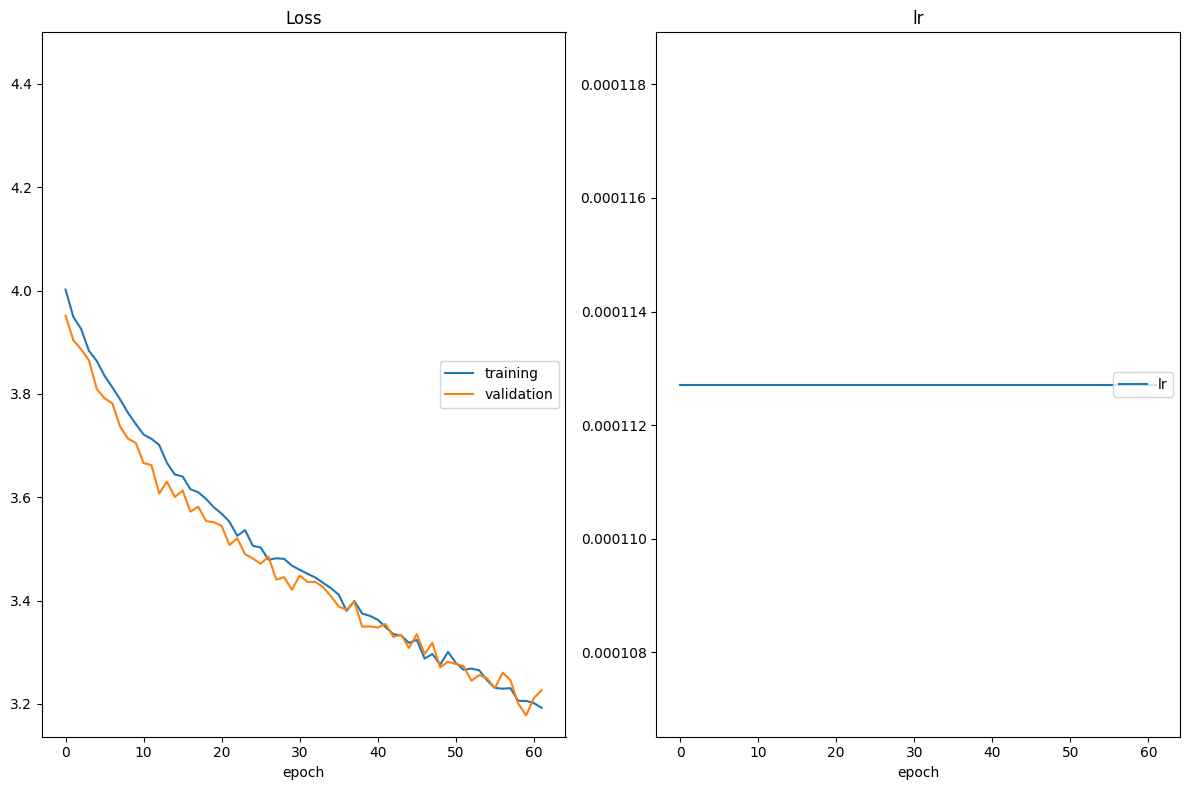

Training:  53%|████████████████▌              | 267/500 [00:12<00:10, 21.48it/s]

In [ ]:
for batch, dropout, opt, lr, decay in zip(batches, dropouts, opts, lrs, decays):
    train_model_once(batch, dropout, opt, lr, decay)

In [5]:
mlflow_client = mlflow.MlflowClient()
runs = mlflow.search_runs()

# Add column for number of epochs we achieved in run before stopping early.
runs['total_epochs'] = runs.apply(lambda row: len(mlflow_client.get_metric_history(row['run_id'], 'epoch_valid_loss')), axis=1)

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 880, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 691, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/utils/file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/notebooks/mlruns/0/.ipynb_checkpoints/meta.ya

In [6]:
# Review any runs that ended early to see if I want to adjust any parameters.
runs[runs['total_epochs'] < num_epochs].head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_accuracy,metrics.epoch_lr,metrics.epoch_train_loss,metrics.epoch_valid_loss,...,params.batch_size,params.dropout,params.learning_rate,params.optimizer,params.weight_decay,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name,total_epochs
0,ef986a9d9df1401e8e57d5ec132b5c3c,0,FINISHED,file:///notebooks/mlruns/0/ef986a9d9df1401e8e5...,2023-06-15 03:59:27.674000+00:00,2023-06-15 04:16:33.636000+00:00,34.099998,0.000459,2.635659,2.755379,...,32,0.4,0.0009173065863634322,adam,0.0005002251410101575,root,LOCAL,big-pig-650,/usr/local/lib/python3.9/dist-packages/ipykern...,56
1,7df6d680ef0c4e5abf298326bc97d5e4,0,FINISHED,file:///notebooks/mlruns/0/7df6d680ef0c4e5abf2...,2023-06-15 03:22:41.703000+00:00,2023-06-15 03:59:26.859000+00:00,29.600000,0.001070,3.152550,3.187714,...,8,0.30000000000000004,0.001069572162284598,adam,0.00013081785249633105,root,LOCAL,indecisive-sheep-959,/usr/local/lib/python3.9/dist-packages/ipykern...,63
2,e53934cd2699494fad692cd3485f27b2,0,FINISHED,file:///notebooks/mlruns/0/e53934cd2699494fad6...,2023-06-15 02:52:38.062000+00:00,2023-06-15 03:22:40.901000+00:00,40.799999,0.000520,2.627506,2.784080,...,8,0.4,0.004163888777594105,sgd,0.0004457509688022053,root,LOCAL,monumental-dog-686,/usr/local/lib/python3.9/dist-packages/ipykern...,68
3,2e81247984c44292ae7e7e331aa8ec84,0,FINISHED,file:///notebooks/mlruns/0/2e81247984c44292ae7...,2023-06-15 02:33:00.272000+00:00,2023-06-15 02:52:37.240000+00:00,37.099998,0.002425,2.469537,2.775798,...,32,0.4,0.004849850162288352,sgd,0.0006873906962470354,root,LOCAL,nervous-crane-379,/usr/local/lib/python3.9/dist-packages/ipykern...,73
4,abaae36244c243f0959072ed66b6ecb6,0,FINISHED,file:///notebooks/mlruns/0/abaae36244c243f0959...,2023-06-15 02:01:39.122000+00:00,2023-06-15 02:32:59.454000+00:00,26.100000,0.000113,3.132490,3.162635,...,8,0.2,0.00011271662653605422,sgd,0.00010669539286632005,root,LOCAL,rogue-rat-854,/usr/local/lib/python3.9/dist-packages/ipykern...,71


In [7]:
sorted_runs = runs.sort_values(by='metrics.val_loss')[[
    'run_id',
    'status',
    'start_time',
    'end_time',
    'metrics.epoch_train_loss',
    'metrics.epoch_lr',
    'metrics.epoch_valid_loss',
    'metrics.val_loss',
    'metrics.val_accuracy',
    'params.batch_size',
    'params.learning_rate',
    'params.optimizer',
    'params.weight_decay',
    'params.dropout',
    'total_epochs']]
sorted_runs.head(15)

,run_id,status,start_time,end_time,metrics.epoch_train_loss,metrics.epoch_lr,metrics.epoch_valid_loss,metrics.val_loss,metrics.val_accuracy,params.batch_size,params.learning_rate,params.optimizer,params.weight_decay,params.dropout,total_epochs
8,ad7467addf924e0a86b3f6b8163cd0f6,FINISHED,2023-06-15 00:29:32.752000+00:00,2023-06-15 00:44:59.082000+00:00,0.318540,0.000037,1.913420,1.748827,56.400002,64,0.0002998372247193153,adam,0.0009493966818808,0.1,56
13,d16a317b378c484cbe6f8fde894a75f8,FINISHED,2023-06-14 22:41:28.720000+00:00,2023-06-14 23:06:19.482000+00:00,0.800191,0.001189,2.358978,1.932160,54.000000,8,0.004754064388985482,sgd,0.0005964904231734222,0.1,56
6,7a79b3ac3b7045c489851a5aa0754f96,FINISHED,2023-06-15 01:08:29.759000+00:00,2023-06-15 01:30:50.442000+00:00,1.943834,0.000752,2.525495,2.080491,47.299999,16,0.003009563908598612,sgd,0.0008103133746352966,0.30000000000000004,69
7,15d81d29142847af8b773a76bd47adbc,FINISHED,2023-06-15 00:45:00.942000+00:00,2023-06-15 01:08:28.944000+00:00,0.869744,0.001083,2.441354,2.085474,48.500000,8,0.004332218967416927,sgd,0.0009659757127438138,0.1,53
9,0babc7a7f2654c23becf02e2f813b137,FINISHED,2023-06-15 00:09:56.672000+00:00,2023-06-15 00:29:31.934000+00:00,2.339586,0.000788,2.663500,2.238314,42.099998,32,0.0007884126564776514,adam,7.440107705542673e-05,0.4,64
2,e53934cd2699494fad692cd3485f27b2,FINISHED,2023-06-15 02:52:38.062000+00:00,2023-06-15 03:22:40.901000+00:00,2.627506,0.000520,2.784080,2.290801,40.799999,8,0.004163888777594105,sgd,0.0004457509688022053,0.4,68
3,2e81247984c44292ae7e7e331aa8ec84,FINISHED,2023-06-15 02:33:00.272000+00:00,2023-06-15 02:52:37.240000+00:00,2.469537,0.002425,2.775798,2.450189,37.099998,32,0.004849850162288352,sgd,0.0006873906962470354,0.4,73
0,ef986a9d9df1401e8e57d5ec132b5c3c,FINISHED,2023-06-15 03:59:27.674000+00:00,2023-06-15 04:16:33.636000+00:00,2.635659,0.000459,2.755379,2.455421,34.099998,32,0.0009173065863634322,adam,0.0005002251410101575,0.4,56
14,a2d3f8c29b53487cb7dce7d18838578b,FINISHED,2023-06-14 22:24:25.627000+00:00,2023-06-14 22:41:27.888000+00:00,2.959593,0.000235,3.052731,2.775792,28.799999,32,0.0018789551930483391,adam,0.0005190920940294755,0.5,56
1,7df6d680ef0c4e5abf298326bc97d5e4,FINISHED,2023-06-15 03:22:41.703000+00:00,2023-06-15 03:59:26.859000+00:00,3.152550,0.001070,3.187714,2.842515,29.600000,8,0.001069572162284598,adam,0.00013081785249633105,0.30000000000000004,63


In [8]:
lowest_loss_id = sorted_runs.iloc[0]['run_id']

# Fetch the best model from that run and store it in our checkpoints for use during testing.
mlflow.artifacts.download_artifacts(run_id=lowest_loss_id, artifact_path='best_val_loss.pt', dst_path='./checkpoints')

'/notebooks/checkpoints/best_val_loss.pt'

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> only run this *after* you have completed hyperpameter optimization. Do not optimize hyperparameters by looking at the results on the test set, or you might overfit on the test set (bad, bad, bad)

Run the code cell below to try out your model on the test dataset of landmark images. Ensure that your test accuracy is greater than 50%.

In [11]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, get_loss())

Testing: 100%|██████████████████████████████████| 40/40 [00:05<00:00,  6.92it/s]

Test Loss: 1.631462


Test Accuracy: 59% (743/1250)


(1.631462386995554, tensor(59.4400))

In [13]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt', map_location='cpu'))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [14]:
import torch

# Load using torch.jit.load
model_reloaded =  torch.jit.load("checkpoints/original_exported.pt")

In [15]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

  0%|                                          | 1/1250 [00:00<08:50,  2.35it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %370 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
100%|███████████████████████████████████████| 1250/1250 [03:33<00:00,  5.84it/s]

Accuracy: 0.58


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

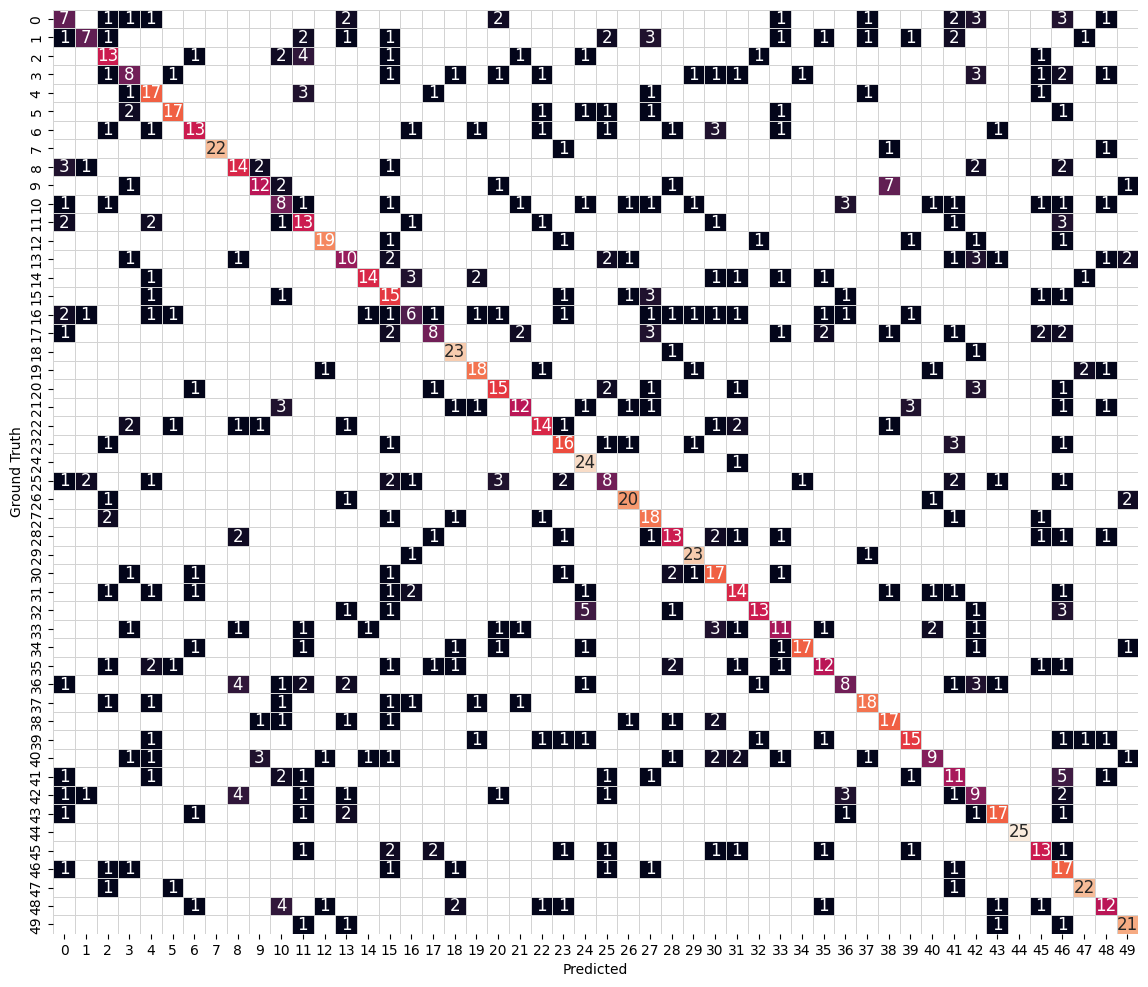

In [16]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)